# Ritwik Khandelwal 18d070061

## Description of method along code and results

### First we carry out speech end-pointing

In [40]:
#Importing Libraries
import numpy as np
from matplotlib import pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib.pyplot import figure
from matplotlib import rcParams
import math
import cmath
from scipy.io.wavfile import write
from scipy.io import wavfile as wav
import scipy.misc
from scipy.io.wavfile import read
from IPython.display import Audio
import librosa
import os
import pickle
import hmmlearn
import itertools
from hmmlearn import hmm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import soundfile as sf

For speech end-pointing, we do by windowing the input audio signals into 20ms width frames. Then, we measure energy of each window frame. Starting from beginning, a starting point is decided as that first frame which has energy greater than 0.005 (decided by observation). Subsequently, end frame is decided by that first frame (after start frame) which has energy less than 0.00001 (decided by observation). We observed there is some silence in the input signal just some frames after the starting frame, which is wrongly selected as end frame. To tackle that, we adjust the code, such that start and stop frames very close to one another don't get selected, this is done by setting a threshold on the number of frames between starting and end frame. (If there are less than a certain, in this case 50, frames between starting and end frame, then the end frame is chosen to be the last frame of the signal.) 

In [41]:
def identify_end_points(filepath):    
    #20ms window length chosen
    j = 0
    temp,serial = librosa.load(filepath)
    sliced = []
    i = np.int(len(temp))
    
    while j<= (i/160)-2:
        m = temp[j*160 : (j+2)*160]
        sliced.append(m)
        j = j+1

    #Finding starting point
    start =0 
    iter_l = 0
    bool_noise = 1 
    updated = 0
    end = len(sliced)-1

    while iter_l<(len(sliced)):
        
        h = np.hamming(320) #320 = 16*20 
        energy = np.matmul(sliced[iter_l]*h,sliced[iter_l]*h)
        
        # start point selection
        if(energy > 0.005):
            if(bool_noise == 1):
                bool_noise = 0
                if updated == 0:
                    updated = 1
                    start = iter_l
                    
        #end point selection 
        if(energy < 0.00001 and bool_noise == 0):
            bool_noise = 1
            end = iter_l
        iter_l = iter_l+1

    d = end-start
    if d < 50:
        end = len(sliced)-1
    end_pointed = np.array(temp[(start*160):((end+2)*160)])
    
    return end_pointed,serial

In [42]:
## Identifying end points for all files

os.listdir('Commands_Dataset/train')

for word in os.listdir('Commands_Dataset/train'): 
    #print(word)
    for sample in os.listdir('Commands_Dataset/train/'+ word): 
        # print(word, sample)
        end_points , samp = identify_end_points('Commands_Dataset/train/'+ word + '/' + sample)
        if np.int(len(end_points)) >10000 :
            sf.write('Commands_Dataset/train_end_points/'+ word + '/' + sample, end_points, samp)


### Next we carry out pre-emphasis and MFCC feature extraction

In [43]:
## Applying Pre-Emphasis

def pre_emphasis(filepath):
    
    high_passed_output = []
    input_temp,serial= librosa.load(filepath)
    high_passed_output.append(np.float(input_temp[0]))
    
    iter_i = 1
    while iter_i< np.int(len(input_temp)):
        temp = np.float(input_temp[iter_i]-0.95*input_temp[iter_i-1])
        high_passed_output.append(temp)
        iter_i = iter_i+1
        
    return high_passed_output,serial



os.listdir('Commands_Dataset/train_end_points')

for word in os.listdir('Commands_Dataset/train_end_points'): 
    #print(word)
    for sample in os.listdir('Commands_Dataset/train_end_points/'+ word): 
        #print(word, sample)
        pre_emph, samp = pre_emphasis('Commands_Dataset/train_end_points/'+ word + '/' + sample)
        sf.write('Commands_Dataset/train_pre_emphasis/'+ word + '/' + sample, pre_emph, samp)
    

We use pre-emphasis just as we did for the previous assignment, we choose alpha = 0.95

In [44]:
## MFCC Feature Extraction

#Using librosa library mfcc feature extraction function
def mfcc(filepath):
    temp ,samp = librosa.load(filepath)
    #mfcc, delta1, delta2
    mfcc_feature = librosa.feature.mfcc(y=temp, sr=samp, n_mfcc=13 ,S=None, dct_type=2, norm='ortho')
    mfcc_delta1 = librosa.feature.delta(mfcc_feature,order=1, mode = 'nearest')
    mfcc_delta2 = librosa.feature.delta(mfcc_feature,order=2, mode = 'nearest')

    mfcc_features = np.concatenate((mfcc_feature, mfcc_delta1 , mfcc_delta2 ), axis=0)
    
    return mfcc_features 

In [45]:
## Loading Training Data 

training = {}  #training dict
for word in os.listdir('Commands_Dataset/train_pre_emphasis'):
    for sample in os.listdir('Commands_Dataset/train_pre_emphasis/'+word):
        actual_word = word
        p = 'Commands_Dataset/train_pre_emphasis/'+word + '/' + sample
        #print(p)
        sample_mfcc = mfcc(p).T
        
        #filling training dict
        if actual_word not in training.keys():
            training[actual_word] = []
            training[actual_word].append(sample_mfcc)
        else:
            temp = training[actual_word]
            temp.append(sample_mfcc)
            training[actual_word] = temp


## Saving training data

with open("training_pre_emphasis_noisy.pkl", "wb") as file:
    pickle.dump(training , file)

In [46]:
def pre_emphasis_file(filesignal):
    high_passed_output = []
    iter_i = 1
    input_temp = filesignal
    high_passed_output.append(np.float(input_temp[0]))
    while iter_i< np.int(len(input_temp)):
        temp = np.float(input_temp[iter_i]-0.95*input_temp[iter_i-1])
        high_passed_output.append(temp)
        iter_i = iter_i+1
    return high_passed_output

def mfcc_file(filesignal,sam):
    temp = np.array(filesignal)
    samp = sam
    #mfcc, delta1, delta2
    mfcc_feature = librosa.feature.mfcc(y=temp, sr=samp, n_mfcc=13 ,S=None, dct_type=2, norm='ortho')
    mfcc_delta = librosa.feature.delta(mfcc_feature,order=1, mode = 'nearest')
    mfcc_delta2 = librosa.feature.delta(mfcc_feature,order=2, mode = 'nearest')
    mfcc_features = np.concatenate((mfcc_feature, mfcc_delta , mfcc_delta2 ), axis=0)
    
    return mfcc_features 

In [47]:
## Task A testing data 

testing_task_a_clean = {}
for word in os.listdir('Commands_Dataset/test_clean'):
    for sample in os.listdir('Commands_Dataset/test_clean/'+word):
        actual_word = word
        p = 'Commands_Dataset/test_clean/'+word + '/' + sample
        endpoints, sa  = identify_end_points(p)
        pre_empf = pre_emphasis_file(endpoints)  
        sample_mfcc = mfcc_file(pre_empf,sa).T
        
        if actual_word not in testing_task_a_clean.keys():
            testing_task_a_clean[actual_word] = []
            testing_task_a_clean[actual_word].append(sample_mfcc)
        else:
            temp = testing_task_a_clean[actual_word]
            temp.append(sample_mfcc)
            testing_task_a_clean[actual_word] = temp

#print('testing A data created')
with open("testA.pkl", "wb") as file:
    pickle.dump(testing_task_a_clean , file)


In [48]:
## Task B testing data
testing_task_b_noisy = {}
for word in os.listdir('Commands_Dataset/test_noisy'):
    for sample in os.listdir('Commands_Dataset/test_noisy/'+word):
        actual_word = word
        p = 'Commands_Dataset/test_noisy/'+word + '/' + sample
        endpoints, sa  = identify_end_points(p)
        pre_empf = pre_emphasis_file(endpoints)  
        sample_mfcc = mfcc_file(pre_empf,sa).T

        if actual_word not in testing_task_b_noisy.keys():
            testing_task_b_noisy[actual_word] = []
            testing_task_b_noisy[actual_word].append(sample_mfcc)
        else:
            temp = testing_task_b_noisy[actual_word]
            temp.append(sample_mfcc)
            testing_task_b_noisy[actual_word] = temp

#print('testing B data created')
with open("testB.pkl", "wb") as file:
    pickle.dump(testing_task_b_noisy , file)


training_data_file  =  open('training_pre_emphasis_noisy.pkl', 'rb')
training = pickle.load(training_data_file)
training_data_file.close()

### Using statistical method of GMM-HMM

In [49]:
## Using hmmlearn
trained_model = {}
hmm_states = 6 #Trial and error

for actual_word in training.keys():

    model = hmm.GaussianHMM(n_components = hmm_states, covariance_type='full', n_iter=5)
    #print(actual_word)
    training_batch = training[actual_word]
    # print(training_batch)
    u = np.zeros([len(training_batch),] ,dtype=np.int)

    temp_length = np.int(len(training_batch))
    for q in range(temp_length):
        u[q] = training_batch[q].shape[0]
    
    training_batch = np.vstack(training_batch)
    #To fit the model, using pre-defined function
    model.fit(training_batch, lengths=u)
    
    trained_model[actual_word] = model

## Saving Model

with open("trained_model.pkl", "wb") as file:
    pickle.dump(trained_model, file)

Here we use class hmmlearn.hmm.GaussianHMM from hmmlearn. By trial and error we select the number of states and to reduce time we keep number of iterations to 5.

In [50]:
## Confusion matrix creation

testA_model_file  =  open('testA.pkl', 'rb')
testing_A_clean = pickle.load(testA_model_file)
testA_model_file.close()

testB_model_file  =  open('testB.pkl', 'rb')
testing_B_noisy = pickle.load(testB_model_file)
testB_model_file.close()

hmm_model_file  =  open('trained_model.pkl', 'rb')
trained_model_hmm = pickle.load(hmm_model_file)
hmm_model_file.close()

In [51]:
## Extracting input features and output labels

# Task A Clean
x_testA = []
y_testA = []
for a in testing_A_clean.keys():
    features = testing_A_clean[a]
    temp = np.int(len(features))
    for t in range(temp):
        y_testA.append(a)
        x_testA.append(features[t])

# Task B Noisy
x_testB = []
y_testB = []
for a in testing_B_noisy.keys():
    features = testing_B_noisy[a]
    temp = np.int(len(features))
    for t in range(temp):
        y_testB.append(a)
        x_testB.append(features[t])

In [52]:
## Prediction Function for given input and trained model

def prediction(test_data, trained):
    score_values = [] 
    words = []
    pred_label = []
    
    for k in trained.keys():
        score_values.append(trained[k].score(test_data))
        words.append(k)
    pred_label.append(score_values.index(max(score_values)))
    
    return words[pred_label[0]]


pred_testA = []
pred_testB = []
#pred_train = []
total_test = 0

for i in range(len(x_testA)):
  y_pred = prediction(x_testA[i],trained_model_hmm )
  if y_pred == y_testA[i]:
      total_test = total_test+ 1
  pred_testA.append(y_pred)

#pred_train = []
total_test = 0

for i in range(len(x_testB)):
  y_pred = prediction(x_testB[i],trained_model_hmm )
  if y_pred == y_testB[i]:
      total_test = total_test+ 1
  pred_testB.append(y_pred)


with open("predtestA.pkl", "wb") as file:
    pickle.dump(pred_testA, file)

trained_model_file  =  open('predtestA.pkl', 'rb')
pred_testA = pickle.load(trained_model_file)
trained_model_file.close()

with open("ytestA.pkl", "wb") as file:
    pickle.dump(y_testA, file)
  
trained_model_file  =  open('ytestA.pkl', 'rb')
y_testA = pickle.load(trained_model_file)
trained_model_file.close()

with open("ytestB.pkl", "wb") as file:
    pickle.dump(y_testB, file)
    
trained_model_file  =  open('ytestB.pkl', 'rb')
y_testB = pickle.load(trained_model_file)
trained_model_file.close()

with open("predtestB.pkl", "wb") as file:
    pickle.dump(pred_testB, file)

trained_model_file  =  open('predtestB.pkl', 'rb')
pred_testB = pickle.load(trained_model_file)
trained_model_file.close()

### Calculating accuracy for both tasks and plotting confusion matrix

Accuracy for Task A =  86.7939228671601 %
Accuracy for Task B =  61.51149201402415 %


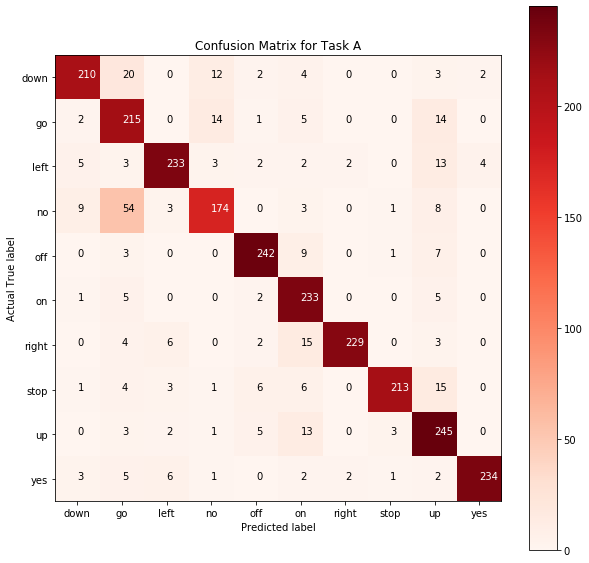

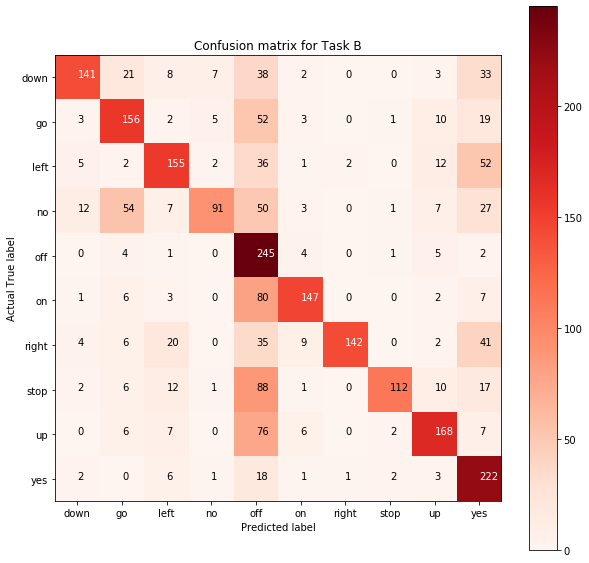

In [56]:
classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

#Task A
confusionmatrix = confusion_matrix(y_testA, pred_testA)
sum_diag_cm = sum(np.diag(confusionmatrix))
sum_cm = sum(sum(confusionmatrix))
acc = 0.0
acc = sum_diag_cm/sum_cm
print('Accuracy for Task A = ',acc*100,'%')

plt.figure(figsize=(10,10))
cmap=plt.cm.Reds
plt.imshow(confusionmatrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix for Task A')
plt.ylabel('Actual True label')
plt.xlabel('Predicted label')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.yticks(tick_marks, classes)
plt.xticks(tick_marks, classes)
level = (confusionmatrix.max())/2
r_start = confusionmatrix.shape[0]
r_end = confusionmatrix.shape[1]
for iter_i, iter_j in itertools.product(range(r_start), range(r_end)):
    plt.text(iter_j, iter_i, format(confusionmatrix[iter_i, iter_j],'d'),color="white" if confusionmatrix[iter_i, iter_j] > level else "black")

#Task B
confusionmatrix = confusion_matrix(y_testB, pred_testB)
sum_diag_cm = sum(np.diag(confusionmatrix))
sum_cm = sum(sum(confusionmatrix))
acc = 0.0
acc = sum_diag_cm/sum_cm
print('Accuracy for Task B = ',acc*100,'%')

plt.figure(figsize=(10,10))
plt.imshow(confusionmatrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix for Task B')
plt.ylabel('Actual True label')
plt.xlabel('Predicted label')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
level = (confusionmatrix.max())/2
r_start = confusionmatrix.shape[0]
r_end = confusionmatrix.shape[1]
for iter_i, iter_j in itertools.product(range(r_start), range(r_end)):
    plt.text(iter_j, iter_i, format(confusionmatrix[iter_i, iter_j],'d'),color="white" if confusionmatrix[iter_i, iter_j] > level else "black")
plt.show()

We observe that accuracy for Task A comes out to be around 86.7%, while that of Task B comes out to be around 61.5%. Also in the confusion matrix we observe that for Task A, the classes 'go' and 'no' are mistaken for one another, which is also the case in real life as these sounds sound similar. Other than this, the model works good in Task A. Now, for task B, the confusion matrix shows that a lot of errors are there. Most strikingly, we see that a lot of samples are classified as 'off'. This could be because the fricative nature of the 'off' sound has some resemblence with the noise that is added in this test. We can make a similar argument for 'yes' sound. Overall, we see that there is a lot of scope of improvement. Even simple things like increasing number of training iterations can be helpful. I didn't increase number of iterations as the current code takes hours to run and so I didn't have time to increase this number of iterations further.